# Data Loading and embedding
In this notebook, we do
1. load toyzero raw window data
1. generate masks
1. patchify and embedding

In [1]:
import numpy as np
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
%load_ext autoreload
%autoreload 2

from models.bert import *

# Paired Toyzero data
Since this dataset was originally the test dataset of cycleGAN and used exclusively for test purpose, in order to use it as both train and test data for this supervised training, we set the first $1000$ pair of images for training and the remaining for test.

In [4]:
def load_image_fnames(dirname):
    """
    load image fnames.
    If amax_dataset_size is not infinity and is less than all available images,
    return a random subset of max_dataset_size image fnames.
    """
    assert Path(dirname).exists(), f"{dirname} doesn't exist"
    image_fnames = np.array(sorted(list(Path(dirname).glob('*npz'))))
    return image_fnames


class ToyzeroAlignedDataset(Dataset):
    def __init__(
            self, 
            dataroot, *, 
            max_dataset_size, 
            serial_batches, 
            train
    ):
        super(ToyzeroAlignedDataset, self).__init__()

        self.serial_batches = serial_batches

        dir_A = Path(dataroot)/f'testA'
        dir_B = Path(dataroot)/f'testB'
        self.image_fnames_A = load_image_fnames(dir_A)
        self.image_fnames_B = load_image_fnames(dir_B)
        
        if train:
            self.image_fnames_A = self.image_fnames_A[:1000]
            self.image_fnames_B = self.image_fnames_B[:1000]
        else:
            self.image_fnames_A = self.image_fnames_A[1000:]
            self.image_fnames_B = self.image_fnames_B[1000:]

        assert len(self.image_fnames_A) == len(self.image_fnames_B), "The dataset is not aligned"
        
        aligned = True
        for fname_A, fname_B in zip(self.image_fnames_A, self.image_fnames_B):
            if fname_A.stem != fname_B.stem:
                aligned = False
                break
        if not aligned:
            print("The dataset is not aligned")
            exit()

        self.size = len(self.image_fnames_A)

        if max_dataset_size != float('inf') and max_dataset_size < self.size:
            indices = np.arange(self.size)
            np.random.shuffle(indices)
            indices = indices[:max_dataset_size]
            self.image_fnames_A = self.image_fnames_A[indices]
            self.image_fnames_B = self.image_fnames_B[indices]
            self.size = max_dataset_size

    def __len__(self):
        return self.size

    def __load(self, image_fname):
        image = np.load(image_fname)
        image = image[image.files[0]]
        image = np.expand_dims(np.float32(image), 0)
        return image

    def __getitem__(self, index):
        if self.serial_batches:
            index = index % self.size
        else:
            index = np.random.randint(0, self.size - 1)
        
        image_A = self.__load(self.image_fnames_A[index])
        image_B = self.__load(self.image_fnames_B[index])

        
        return {
            'A': image_A, 
            'B': image_B, 
        }


# Patchify and depatchify

In [5]:
def patchify(x, patch_size):
    """
    Cut a batch of images into non-overlapping patches and stack them
    Input:
        - x (Tensor): The input tensor with shape (batch_size(N), n_channels(C), height(H), width(W));
        - patch_size (int): the side length of the patch, which means each patch is of size (patch_size, patch_size);
    Output:
        Tensor of shape (batch_size * num_patches, n_channel, patch_size, patch_size).
        The first 1 through num_patches belongs to the first image 
        and the num_patches + 1 through 2 * num_patches belongs to the second image, etc.
    """
    batch_size = x.size(0)
    height, width  = x.size(-2), x.size(-1)
    assert height % patch_size == 0, f'height of image must be divisible by patch_size, but {height} % {patch_size} != 0!'
    assert width % patch_size == 0, f'width of image must be divisible by patch_size, but {width} % {patch_size} != 0!'
    
    
    patches = [
        x[b, :, i: i + patch_size, j: j + patch_size].unsqueeze(0)
        for b in range(batch_size)
        for i in range(0, height, patch_size)
        for j in range(0, width, patch_size)
    ]
    return torch.cat(patches, dim=0)


def depatchify(x, batch_size, height=None, width=None):
    """
    Assemble the patches back to a image.
    NOTE: We assume that each patch is a square.
    Input:
        - x (Tensor): The input tensor with shape (batch_size * num_patches, n_channel, patch_size, patch_size);
        - batch_size (int): number of FULL images in a batch;
        - height (ing): height of the image; If given, assumed to be divisible by patch_size;
        - width (int): width of the image; If given, assumed to be divisible by patch_size.
        NOTE: If only one of height or width is given, infer the other one. If neither is given, assume image to be square
    """
    patch_size = x.size(-1)
    # Number of patches per image
    assert x.size(0) % batch_size == 0, \
        f'the first dimension of input tensor ({x.size(0)}) should be divisible by batch_size ({batch_size})'
    num_patches = x.size(0) // batch_size
    
    # Number of patches along each edge
    if height:
        assert height % patch_size == 0, \
            f'height ({height}) of image must be divisible by patch_size ({patch_size}'
        num_patches_height = height // patch_size
    if width:
        assert width % patch_size == 0, \
            f'width ({width}) of image must be divisible by patch_size ({patch_size}'
        num_patches_width = width // patch_size
    if height and not width:
        assert num_patches % num_patches_height, \
            f'number of patches ({num_patches}) must be divisible by the number of patches along the height ({num_patches_height})'
        num_patches_width = num_patches // num_patches_height
    elif width and not height:
        assert num_patches % num_patches_width, \
            f'number of patches ({num_patches}) must be divisible by the number of patches along the width ({num_patches_width})'
        num_patches_height = num_patches // num_patches_width
    elif width and height:
        assert num_patches == num_patches_height * num_patches_width, \
            f'the number of patches along the height ({num_patches_height}) times the number of patches along the width ({num_patches_width}) must equal total number of patches ({num_patches})'
    else:
        num_patches_edge = int(np.sqrt(num_patches))
        assert num_patches_edge * num_patches_edge  == num_patches, "cannot make a square image"
        num_patches_height = num_patches_edge
        num_patches_width = num_patches_edge
        
    # Reshaping
    patches = x.view(-1, num_patches, *x.shape[1:])
    images = []
    for I in patches:
        # each I is for one image
        rows = []
        for i in range(num_patches_height):
            start = i * num_patches_width
            row = torch.cat([I[start + j] for j in range(num_patches_width)], dim=-1)
            rows.append(row)
        image = torch.cat(rows, dim=-2)
        image = torch.unsqueeze(image, 0)
        images.append(image)
    return torch.cat(images, dim=0)


# ================================= Test  ================================= 
patch_size = 5
height, width= 10, 15
batch_size = 2

x = np.random.randint(0, 10, size=(batch_size, 1, height, width))
x = torch.from_numpy(x)
p = patchify(x, patch_size)
print(p.shape)
y = depatchify(p, batch_size, height, width)
# print(x == y)
print(x)
print()
print(y)

torch.Size([12, 1, 5, 5])
tensor([[[[1, 3, 4, 5, 5, 6, 8, 4, 5, 8, 2, 2, 0, 0, 5],
          [3, 0, 5, 7, 5, 9, 6, 4, 3, 8, 8, 4, 2, 6, 6],
          [8, 7, 5, 8, 5, 0, 2, 1, 0, 4, 0, 4, 1, 7, 4],
          [4, 6, 1, 1, 0, 6, 3, 8, 1, 7, 5, 8, 2, 9, 8],
          [3, 6, 7, 1, 3, 6, 5, 1, 9, 1, 9, 5, 2, 3, 0],
          [9, 2, 6, 6, 7, 3, 3, 1, 3, 3, 4, 6, 3, 3, 7],
          [6, 0, 7, 4, 7, 4, 2, 6, 8, 7, 0, 6, 2, 1, 0],
          [1, 8, 2, 7, 2, 4, 6, 8, 0, 7, 1, 6, 1, 4, 1],
          [5, 4, 8, 0, 9, 8, 2, 9, 0, 5, 3, 3, 7, 8, 6],
          [3, 6, 2, 3, 5, 6, 1, 7, 3, 1, 2, 7, 3, 6, 3]]],


        [[[5, 2, 5, 1, 7, 7, 1, 0, 3, 8, 6, 0, 4, 4, 7],
          [7, 1, 0, 9, 2, 4, 7, 2, 9, 0, 2, 7, 2, 5, 2],
          [7, 5, 9, 0, 6, 3, 6, 4, 8, 4, 2, 9, 8, 0, 6],
          [4, 8, 1, 3, 8, 3, 8, 3, 7, 8, 2, 0, 5, 8, 6],
          [1, 1, 9, 5, 0, 1, 0, 2, 1, 3, 4, 1, 8, 4, 7],
          [6, 4, 6, 2, 8, 3, 2, 5, 8, 3, 9, 8, 1, 0, 4],
          [2, 5, 4, 3, 0, 2, 8, 0, 1, 6, 3, 4, 0, 1, 1],
 

# Embedding and Generator

## Embedding

In [6]:
class Embedding(nn.Module):
    def __init__(self, d_model, image_height, image_width, patch_size, mode='conv', leading=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_height (int): image height
            - image_width (int): image width
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.image_height = image_height
        self.image_width = image_width
        self.patch_size = patch_size
        self.leading = leading
        if not leading:
            self.source = False
        
        if mode == 'conv':
            num_patches =  (image_height // patch_size) * (image_width // patch_size)
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = 1
            out_channels = d_model // num_channel_base
            for i in range(num_layers - 1):
                conv_blocks += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
                out_channels *= 2
            conv_blocks.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp       
    
    def forward(self, x):
        # sanity check and get number of patches
        assert x.size(-2) == self.image_height, f'input tensor height ({x.size(-2)}) not equal to image_height ({self.image_height})'
        assert x.size(-1) == self.image_width, f'input tensor width ({x.size(-1)}) not equal to image_width ({self.image_width})'
        num_patches = (x.size(-2) // self.patch_size) * (x.size(-1) // self.patch_size)
        
        # Patchify
        p = patchify(x, self.patch_size)
        
        # Convolution
        for i, layer in enumerate(self.layers):
            p = layer(p)
        
        # Re-organize the convolution output into a form that is acceptable to transformer
        p = p.squeeze()
        tokenized_images = []
        for start in range(0, p.size(0), num_patches):
            tokenized_image = p[start: start + num_patches]
            if self.leading:
                # Now, the tokenized_image is of shape (seq_len, embedding_length), and
                # we need to add one row of ones as the top row.
                # The parameter 'pad' is in the order (left, right, top, bottom).
                tokenized_image = F.pad(tokenized_image, pad=(0, 0, 1, 0), mode='constant', value=1)
            tokenized_image = tokenized_image.unsqueeze(0)
            tokenized_images.append(tokenized_image)
        T = torch.cat(tokenized_images, dim=0)    
        return T * np.sqrt(self.d_model)

## Generator

In [7]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """
    def __init__(self, d_model, image_height, image_width, patch_size, mode='conv', leading=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_height (int): image height
            - image_width (int): image width
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Generator, self).__init__()
        self.d_model = d_model
        self.image_height = image_height
        self.image_width = image_width
        self.patch_size = patch_size
        self.leading = leading
        if mode == 'conv':
            num_patches =  (image_height // patch_size) * (image_width // patch_size)
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = d_model
            for i in range(num_layers - 1):
                out_channels = in_channels // 2
                conv_blocks += [
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
            conv_blocks.append(nn.ConvTranspose2d(in_channels, 1, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp
    
    def forward(self, x):
        """
        Input:
            - x (Tensor): tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        
        # 1) Stack the embedded tokens from each sequence 
        #    and get a tensor of shape (batch_size x seq_len, d_model).
        if self.leading:
            x = torch.cat([tokenized_image[1:] for tokenized_image in x], dim=0)
        else:
            x = torch.cat([tokenized_image for tokenized_image in x], dim=0)
        # 2) Add width=1 and height=1 to the end of the tensor and 
        #    get a tensor of shape (batch_size x seq_len, d_model, 1, 1).
        x = x.unsqueeze(-1).unsqueeze(-1)
        # 3) Apply deconvolution, decrease the number of freatures
        #    while increasing the image size, so that the output
        #    has shape (batch_size x seq_len, 1, patch_size, patch_size).
        for i, layer in enumerate(self.layers):
            x = layer(x)
        # 4) Depatchify the patches back to images.
        #    The seq_len is the number of patches, which is a square.
        #    The number of patches along each side, P, is the square root of seq_len
        #    The resulting tensor is of size 
        #    (batch_size, 1, patch_size * P, patch_size * P), 
        #    where patch_size * P is the side length of the original image.
        x = depatchify(x, batch_size, self.image_height, self.image_width)
        return x

## Test the Embedding and Generator

In [8]:
# Set the device, either 'cuda' or 'cpu'
device = 'cuda'

# Load data
dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
max_dataset_size = 2
serial_batches = True
# batch_size = max_dataset_size
batch_size = 2

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    # patch_size=16
    train=True
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)
data = next(iter(loader))

# Set parameter
image_size = 128
patch_size = 16
d_model = 256
leading = False

# Embedding
eb = Embedding(d_model, image_size, image_size, patch_size, mode='conv', leading=leading).to(device)
embedding = eb(data['A'].to(device))
print(embedding.shape)

# Generator
gr = Generator(d_model, image_size, image_size, patch_size, mode='conv', leading=leading).to(device)
images = gr(embedding)
print(images.shape)

torch.Size([2, 64, 256])
torch.Size([2, 1, 128, 128])


# Training the BERT

## Make model

In [9]:
def make_model(
    image_height,
    image_width,
    patch_size, *,
    N=6,
    d_model=512,
    d_ff=2048,
    h=8,
    dropout=.1, 
    mode='conv',
    leading=False,
):
    """
    Construct a model from hyperparameters
    Input:
        - image_size (int): images are supposed to be square, and the image_size is the side length.
        - patch_size (int): patches are supposed to be square, and the patch_size is the side length.
        - N (int): number of encoder and decoder blocks.
        - d_model (int): d_model is the embedding length of each token. d_model must be divisible by h (number of heads).
        - d_ff (int): hidden units in the hidden layer of the feed-forward block.
        - h (int): number of heads in the multiheaded attention.
        - dropout (float): dropout rate used in many places in the network.
        - mode (string): way of embedding and generator.
        - leading (bool): whether to add a leading token to the embedded sequence (sequence of patches in our case).
    """

    C = copy.deepcopy

    attn = MultiHeadedAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    encoder = Encoder(EncoderLayer(d_model, C(attn), C(ff), dropout), N)
    embedding = Embedding(d_model, image_height, image_width, patch_size, mode=mode, leading=leading)
    generator = Generator(d_model, image_height, image_width, patch_size, mode=mode, leading=leading)

    model = Bert(
        encoder,
        nn.Sequential(embedding, C(position)),
        generator
    )

    # (author of this blog): This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Utility functions for training

In [10]:
def SimplePlot(x, out, y, kwargs=None):
    
    num_samples = 5
    cmap = 'bwr'
    if kwargs:
        if num_samples in kwargs:
            num_samples = kwargs['num_samples']
        if cmap in kwargs:
            cmap = kwargs['cmap']
    
    total_samples = x.size(0)
    indices = np.random.choice(total_samples, num_samples, replace=False)
    images = torch.stack([x[indices], out[indices], y[indices]]).squeeze().transpose_(0, 1).detach().cpu().numpy()
    
    width = 4
    fig, axes = plt.subplots(num_samples, 3, figsize=(3 * width * 1.1, num_samples * width))
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            image = images[i][j]
            vmin, vmax = image.min(), image.max()
            if vmin == 0:
                vmin = -.05
            if vmax == 0:
                vmax = .05
            divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
            ax.set_aspect(1)
            im = ax.pcolormesh(images[i][j], cmap=cmap, norm=divnorm)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')
    plt.tight_layout()
    
    # block=False for immediate plotting. 
    # Otherwise, the plots will show all at once at the end.
    plt.show(block=False) 
    
# # ========================== Test ==========================
# x = torch.randn(10, 1, 128, 128)
# out = torch.randn(10, 1, 128, 128)
# y = torch.randn(10, 1, 128, 128)
# plot(x, out, y)

In [16]:
def run_epoch(batches, model, loss_compute, logging_freq=50, plot_func=None, plot_kwargs=None):
    """
    Standard training and logging function
    """    
    start = time.time()
    total_loss = 0 # cumulative loss
    total_image = 0

    for i, batch in enumerate(batches):
        x = batch['A'].to(device)
        y = batch['B'].to(device)
        out = model(x)
        
        loss = loss_compute(out, y)
        num_images = batch['A'].size(0)
        total_loss += loss * batch['A'].size(0)
        total_image += num_images

        if logging_freq > 0:
            if i % logging_freq == logging_freq - 1:
                elapsed = time.time() - start
                print(f'\tIteration: {i + 1}')
                print(f'\t\tCurrent loss per image:\t{loss / num_images:.6f}')
                print(f'\t\tAvg. time per batch:\t{elapsed / logging_freq:.6f}')
                start = time.time()
    if plot_func:
        if plot_kwargs:
            plot_func(x, out, y, plot_kwargs)
        else:
            plot_func(x, out, y) 
            
    return total_loss / total_image

In [17]:
class NoamOpt:
    """
    Optim wrapper that implements learning rate.
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

        self._a = self.factor * (self.model_size ** -.5)
        self._b = self.warmup ** (-1.5)

    def step(self):
        """
        update parameters and rate
        """
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate

        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        """
        Implement lr as defined above.
        """
        if step is None:
            step = self._step
        return self._a * min(step ** (-.5), step * self._b)

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class LossCompute:
    """
    A simple loss compute and train function.
    """
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y):
        loss = self.criterion(x, y)
        
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        
        return loss.item()

## Parameters and data

In [19]:
# Set parameter
dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
# Set the device, either 'cuda' or 'cpu'
device = 'cuda'
image_size = 128
patch_size = 16
d_model = 512
leading = False

# Load train data
max_dataset_size = 1000
serial_batches = True
# batch_size = max_dataset_size
batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    train=True
)
loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

# Load valid data
max_dataset_size = 1000
serial_batches = True
batch_size = max_dataset_size
# batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    train=False
)
loader_valid = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

checkpoint_freq = 20
plot_freq = 20
checkpoint_folder = 'checkpoints/bert'
if not Path(checkpoint_folder).exists():
    Path(checkpoint_folder).mkdir(parents=True)

## Train

number of parameters = 5.08M
Epoch 1 / 200
	lr:		0.000000 -> 0.007813
	time per epoch:	8.118725 seconds
	train loss:	1.295912
	valid loss:	1.339681
	peak memory use:	26.902G
Epoch 2 / 200
	lr:		0.007813 -> 0.005524
	time per epoch:	7.904570 seconds
	train loss:	1.232382
	valid loss:	1.311012
	peak memory use:	26.902G
Epoch 3 / 200
	lr:		0.005524 -> 0.004511
	time per epoch:	7.919985 seconds
	train loss:	1.210357
	valid loss:	1.295679
	peak memory use:	26.902G
Epoch 4 / 200
	lr:		0.004511 -> 0.003906
	time per epoch:	7.884197 seconds
	train loss:	1.201150
	valid loss:	1.290809
	peak memory use:	26.902G
Epoch 5 / 200
	lr:		0.003906 -> 0.003494
	time per epoch:	7.871703 seconds
	train loss:	1.186868
	valid loss:	1.256812
	peak memory use:	26.902G
Epoch 6 / 200
	lr:		0.003494 -> 0.003189
	time per epoch:	7.998947 seconds
	train loss:	1.138812
	valid loss:	1.189346
	peak memory use:	26.902G
Epoch 7 / 200
	lr:		0.003189 -> 0.002953
	time per epoch:	7.919846 seconds
	train loss:	1.061863
	val

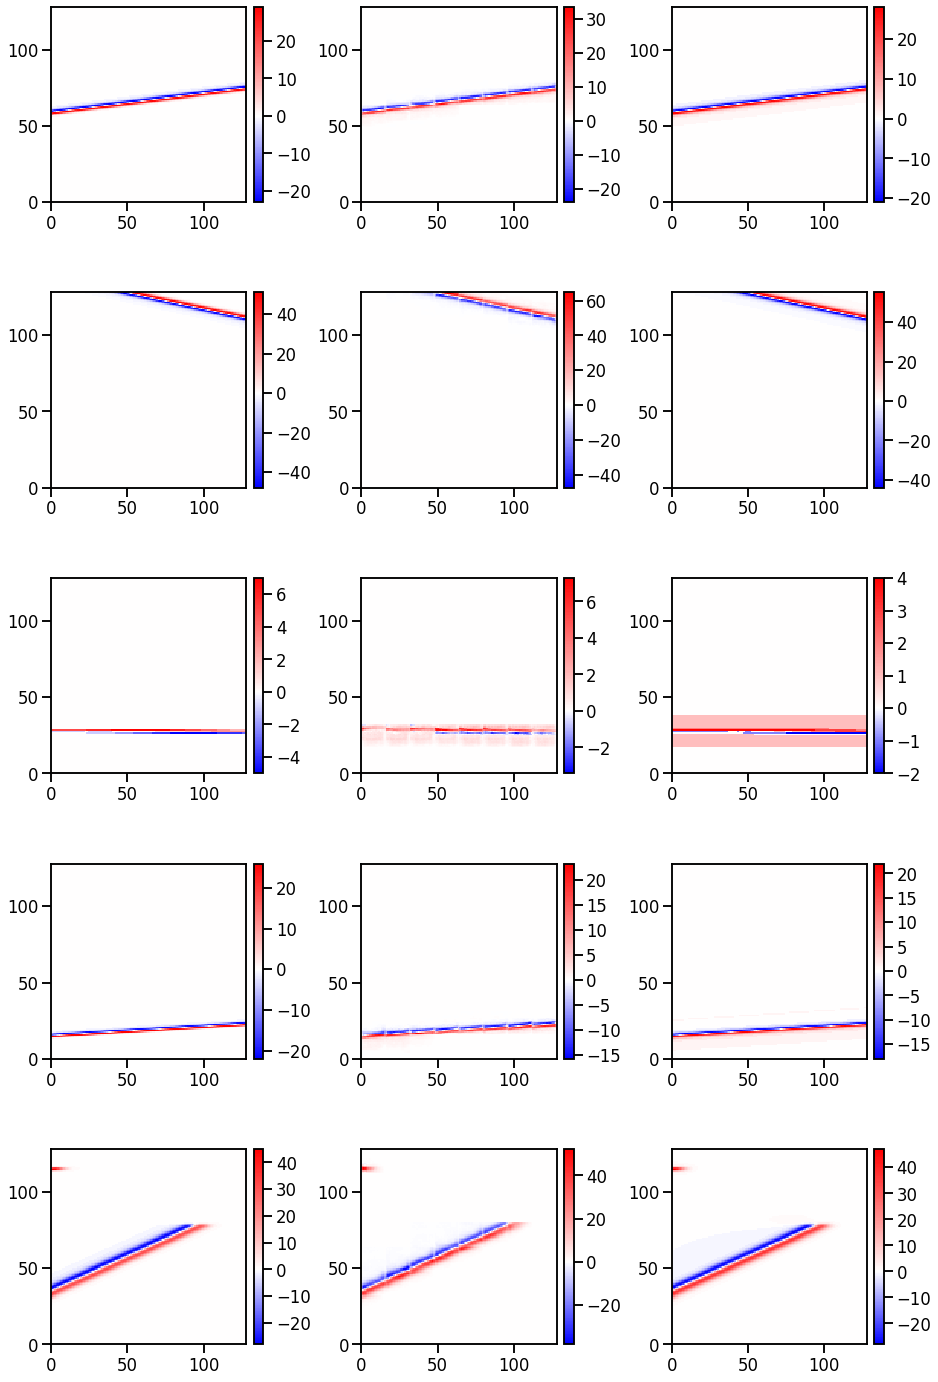

	valid loss:	0.378926
	Saving checkpoint
	peak memory use:	26.902G
Epoch 21 / 200
	lr:		0.001747 -> 0.001705
	time per epoch:	8.008614 seconds
	train loss:	0.384440
	valid loss:	0.378319
	peak memory use:	26.902G
Epoch 22 / 200
	lr:		0.001705 -> 0.001666
	time per epoch:	7.900614 seconds
	train loss:	0.365582
	valid loss:	0.370643
	peak memory use:	26.902G
Epoch 23 / 200
	lr:		0.001666 -> 0.001629
	time per epoch:	7.902891 seconds
	train loss:	0.378469
	valid loss:	0.368871
	peak memory use:	26.902G
Epoch 24 / 200
	lr:		0.001629 -> 0.001595
	time per epoch:	8.009603 seconds
	train loss:	0.344238
	valid loss:	0.345356
	peak memory use:	26.902G
Epoch 25 / 200
	lr:		0.001595 -> 0.001563
	time per epoch:	7.958244 seconds
	train loss:	0.361137
	valid loss:	0.404735
	peak memory use:	26.902G
Epoch 26 / 200
	lr:		0.001563 -> 0.001532
	time per epoch:	7.958340 seconds
	train loss:	0.376751
	valid loss:	0.338823
	peak memory use:	26.902G
Epoch 27 / 200
	lr:		0.001532 -> 0.001504
	time per epoch

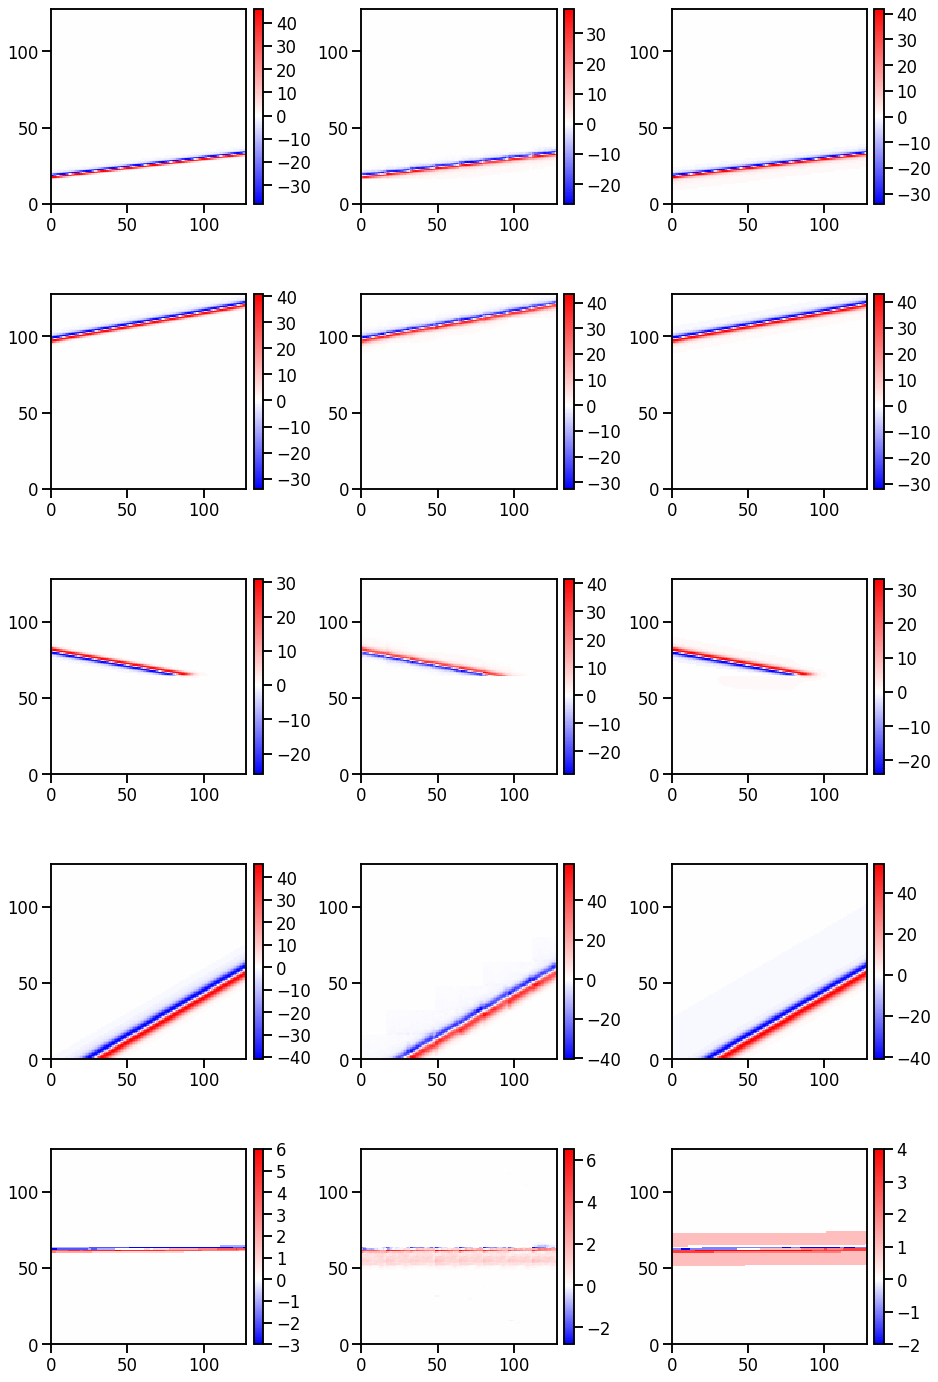

	valid loss:	0.369698
	Saving checkpoint
	peak memory use:	26.902G
Epoch 41 / 200
	lr:		0.001235 -> 0.001220
	time per epoch:	7.982700 seconds
	train loss:	0.308624
	valid loss:	0.365629
	peak memory use:	26.902G
Epoch 42 / 200
	lr:		0.001220 -> 0.001205
	time per epoch:	7.915886 seconds
	train loss:	0.283445
	valid loss:	0.298625
	peak memory use:	26.902G
Epoch 43 / 200
	lr:		0.001205 -> 0.001191
	time per epoch:	7.901207 seconds
	train loss:	0.306619
	valid loss:	0.301053
	peak memory use:	26.902G
Epoch 44 / 200
	lr:		0.001191 -> 0.001178
	time per epoch:	7.993820 seconds
	train loss:	0.310922
	valid loss:	0.301259
	peak memory use:	26.902G
Epoch 45 / 200
	lr:		0.001178 -> 0.001165
	time per epoch:	7.928221 seconds
	train loss:	0.307499
	valid loss:	0.338488
	peak memory use:	26.902G
Epoch 46 / 200
	lr:		0.001165 -> 0.001152
	time per epoch:	7.948244 seconds
	train loss:	0.289316
	valid loss:	0.293635
	peak memory use:	26.902G
Epoch 47 / 200
	lr:		0.001152 -> 0.001140
	time per epoch

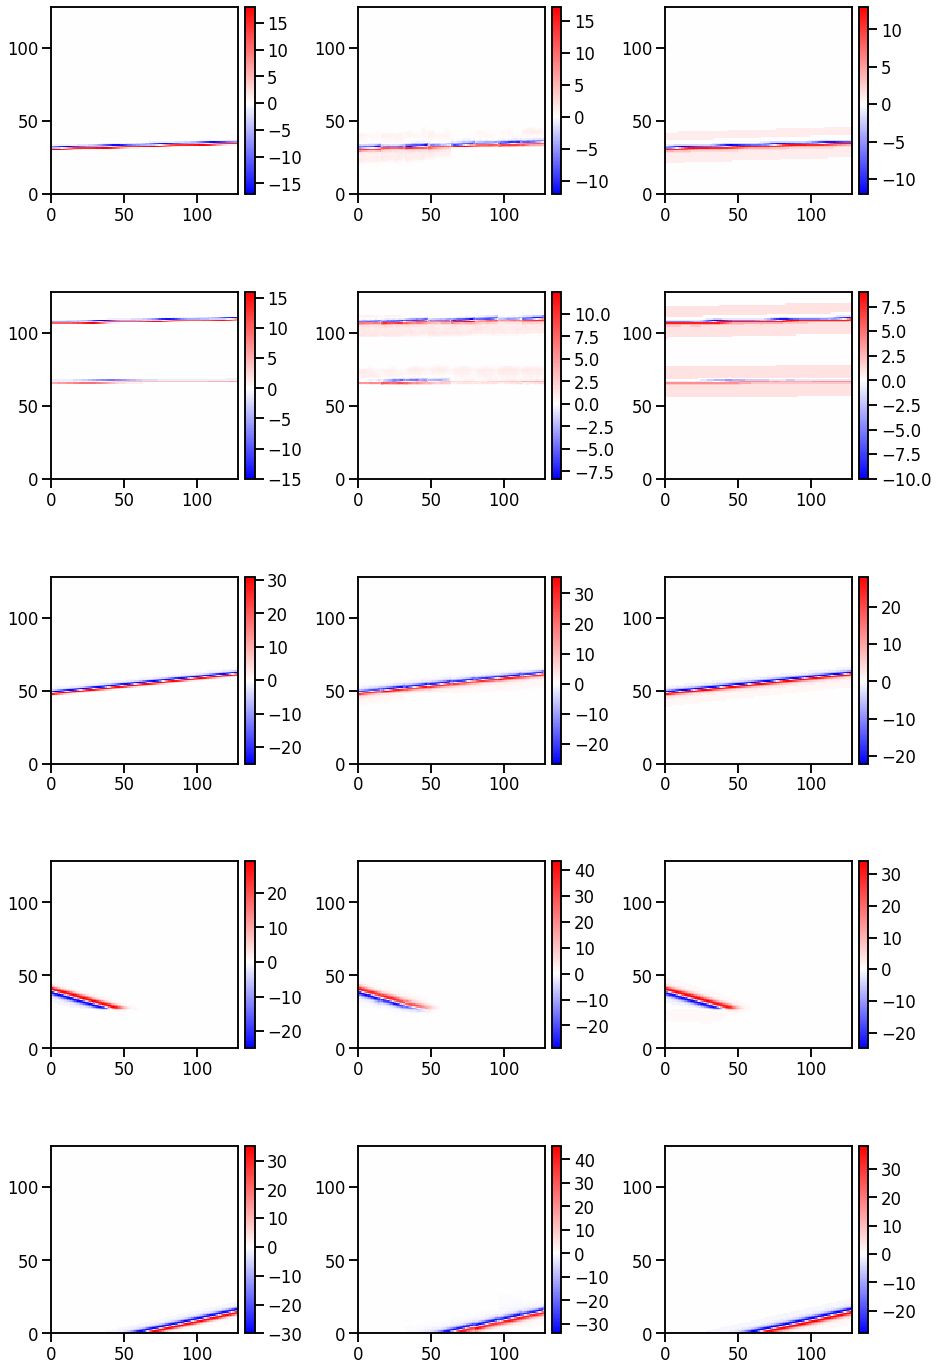

	valid loss:	0.287337
	Saving checkpoint
	peak memory use:	26.902G
Epoch 61 / 200
	lr:		0.001009 -> 0.001000
	time per epoch:	7.970871 seconds
	train loss:	0.304252
	valid loss:	0.293533
	peak memory use:	26.902G
Epoch 62 / 200
	lr:		0.001000 -> 0.000992
	time per epoch:	7.910837 seconds
	train loss:	0.278286
	valid loss:	0.280403
	peak memory use:	26.902G
Epoch 63 / 200
	lr:		0.000992 -> 0.000984
	time per epoch:	7.910465 seconds
	train loss:	0.267764
	valid loss:	0.287855
	peak memory use:	26.902G
Epoch 64 / 200
	lr:		0.000984 -> 0.000977
	time per epoch:	8.003171 seconds
	train loss:	0.251429
	valid loss:	0.280901
	peak memory use:	26.902G
Epoch 65 / 200
	lr:		0.000977 -> 0.000969
	time per epoch:	7.940909 seconds
	train loss:	0.260434
	valid loss:	0.270067
	peak memory use:	26.902G
Epoch 66 / 200
	lr:		0.000969 -> 0.000962
	time per epoch:	7.936011 seconds
	train loss:	0.279432
	valid loss:	0.325655
	peak memory use:	26.902G
Epoch 67 / 200
	lr:		0.000962 -> 0.000954
	time per epoch

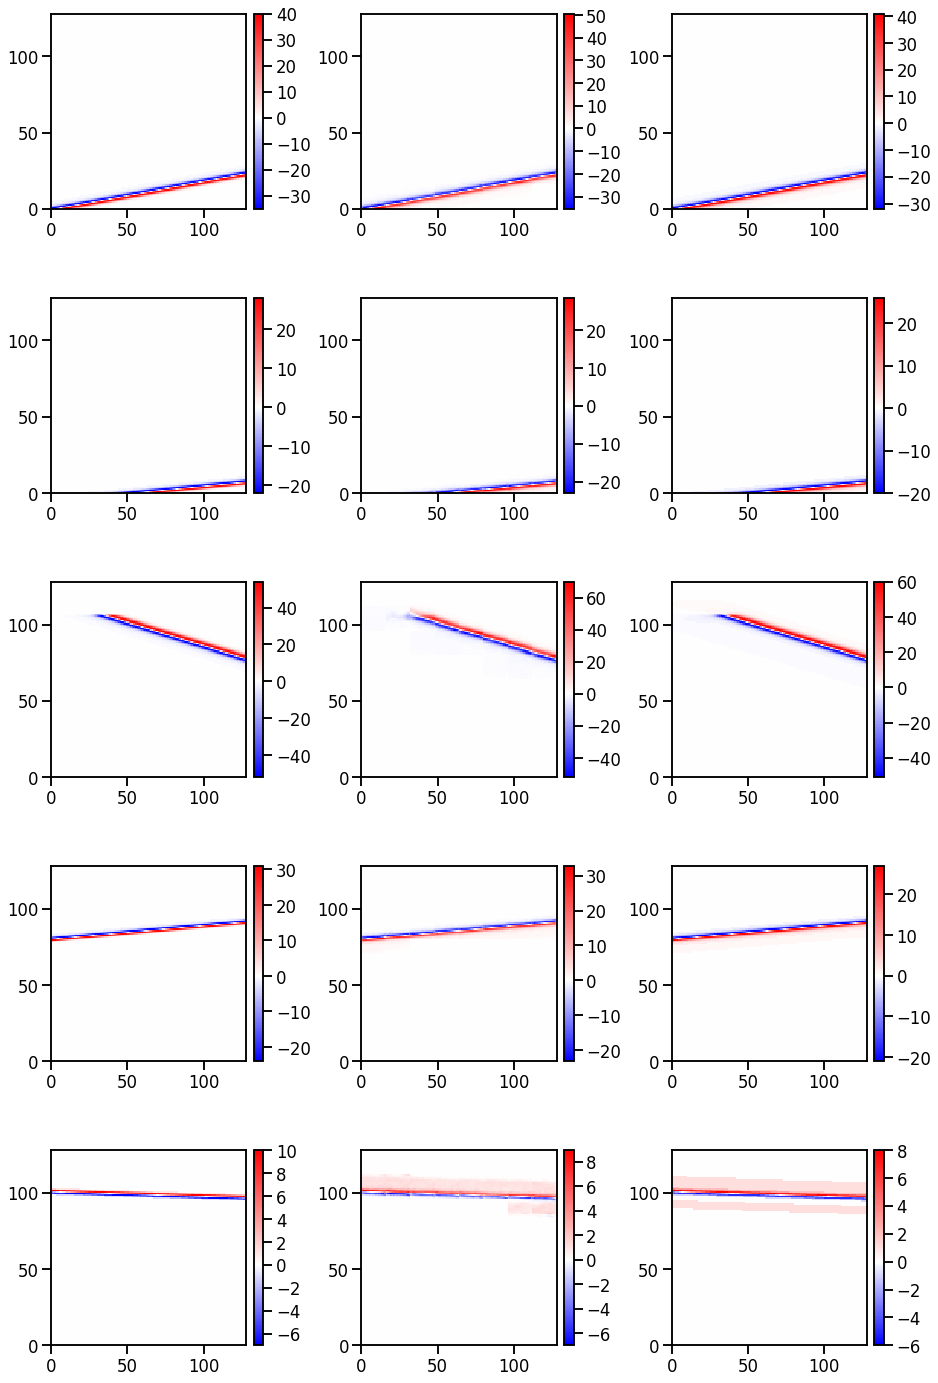

	valid loss:	0.260192
	Saving checkpoint
	peak memory use:	26.902G
Epoch 81 / 200
	lr:		0.000873 -> 0.000868
	time per epoch:	7.954187 seconds
	train loss:	0.246529
	valid loss:	0.267783
	peak memory use:	26.902G
Epoch 82 / 200
	lr:		0.000868 -> 0.000863
	time per epoch:	7.923182 seconds
	train loss:	0.249558
	valid loss:	0.290562
	peak memory use:	26.902G
Epoch 83 / 200
	lr:		0.000863 -> 0.000858
	time per epoch:	7.903804 seconds
	train loss:	0.244802
	valid loss:	0.266048
	peak memory use:	26.902G
Epoch 84 / 200
	lr:		0.000858 -> 0.000852
	time per epoch:	7.960750 seconds
	train loss:	0.246358
	valid loss:	0.280158
	peak memory use:	26.902G
Epoch 85 / 200
	lr:		0.000852 -> 0.000847
	time per epoch:	7.986531 seconds
	train loss:	0.262425
	valid loss:	0.265686
	peak memory use:	26.902G
Epoch 86 / 200
	lr:		0.000847 -> 0.000842
	time per epoch:	7.924574 seconds
	train loss:	0.247764
	valid loss:	0.301218
	peak memory use:	26.902G
Epoch 87 / 200
	lr:		0.000842 -> 0.000838
	time per epoch

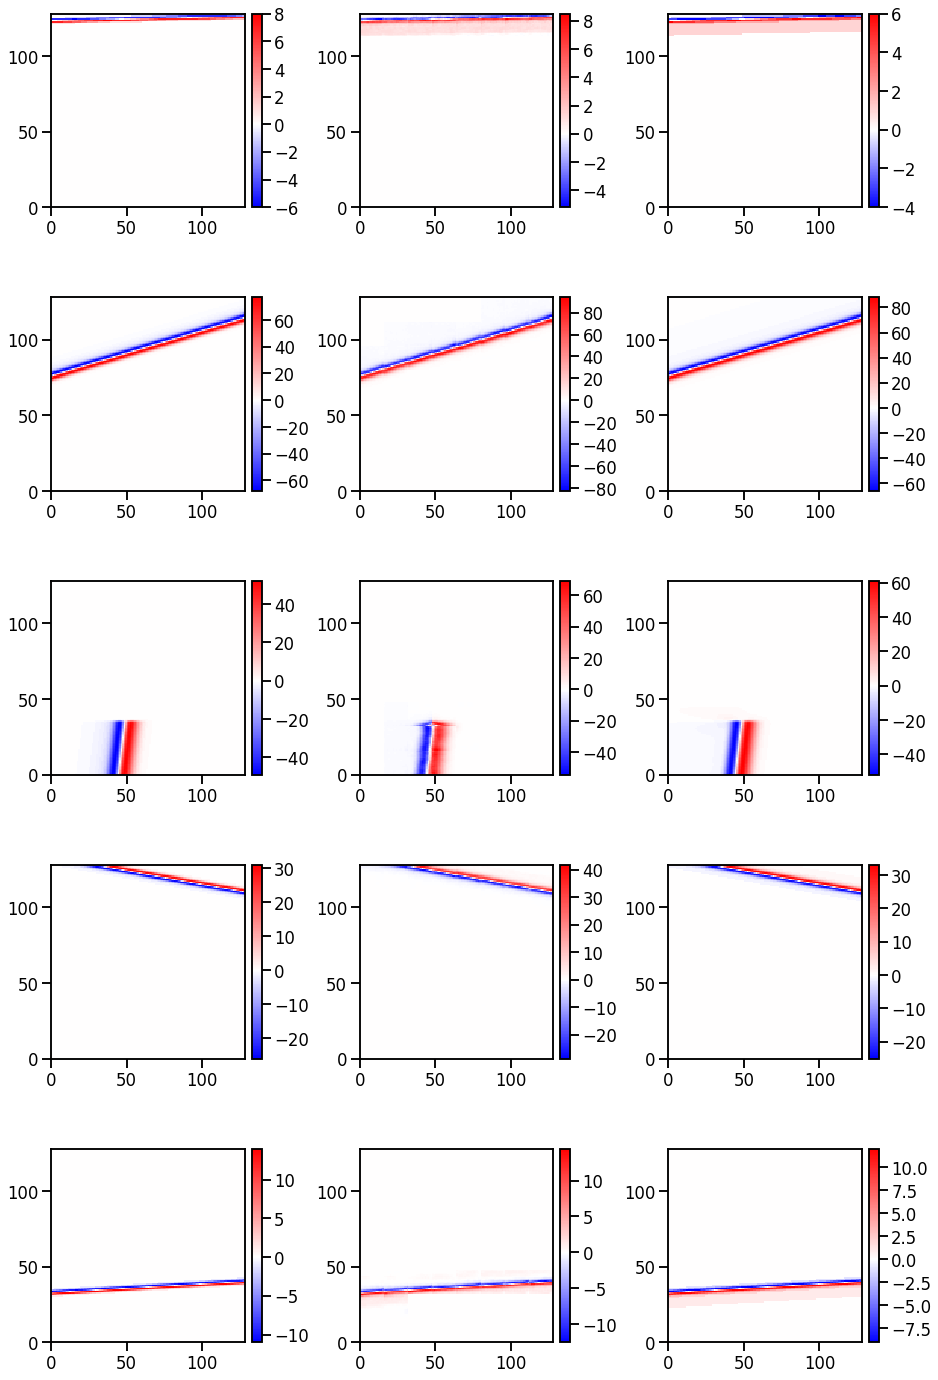

	valid loss:	0.258623
	Saving checkpoint
	peak memory use:	26.902G
Epoch 101 / 200
	lr:		0.000781 -> 0.000777
	time per epoch:	7.957133 seconds
	train loss:	0.245936
	valid loss:	0.290539
	peak memory use:	26.902G
Epoch 102 / 200
	lr:		0.000777 -> 0.000774
	time per epoch:	7.933063 seconds
	train loss:	0.238584
	valid loss:	0.250987
	peak memory use:	26.902G
Epoch 103 / 200
	lr:		0.000774 -> 0.000770
	time per epoch:	7.939323 seconds
	train loss:	0.235285
	valid loss:	0.250519
	peak memory use:	26.902G
Epoch 104 / 200
	lr:		0.000770 -> 0.000766
	time per epoch:	8.005832 seconds
	train loss:	0.236470
	valid loss:	0.269279
	peak memory use:	26.902G
Epoch 105 / 200
	lr:		0.000766 -> 0.000762
	time per epoch:	7.924603 seconds
	train loss:	0.241015
	valid loss:	0.272365
	peak memory use:	26.902G
Epoch 106 / 200
	lr:		0.000762 -> 0.000759
	time per epoch:	7.940780 seconds
	train loss:	0.241067
	valid loss:	0.262710
	peak memory use:	26.902G
Epoch 107 / 200
	lr:		0.000759 -> 0.000755
	time pe

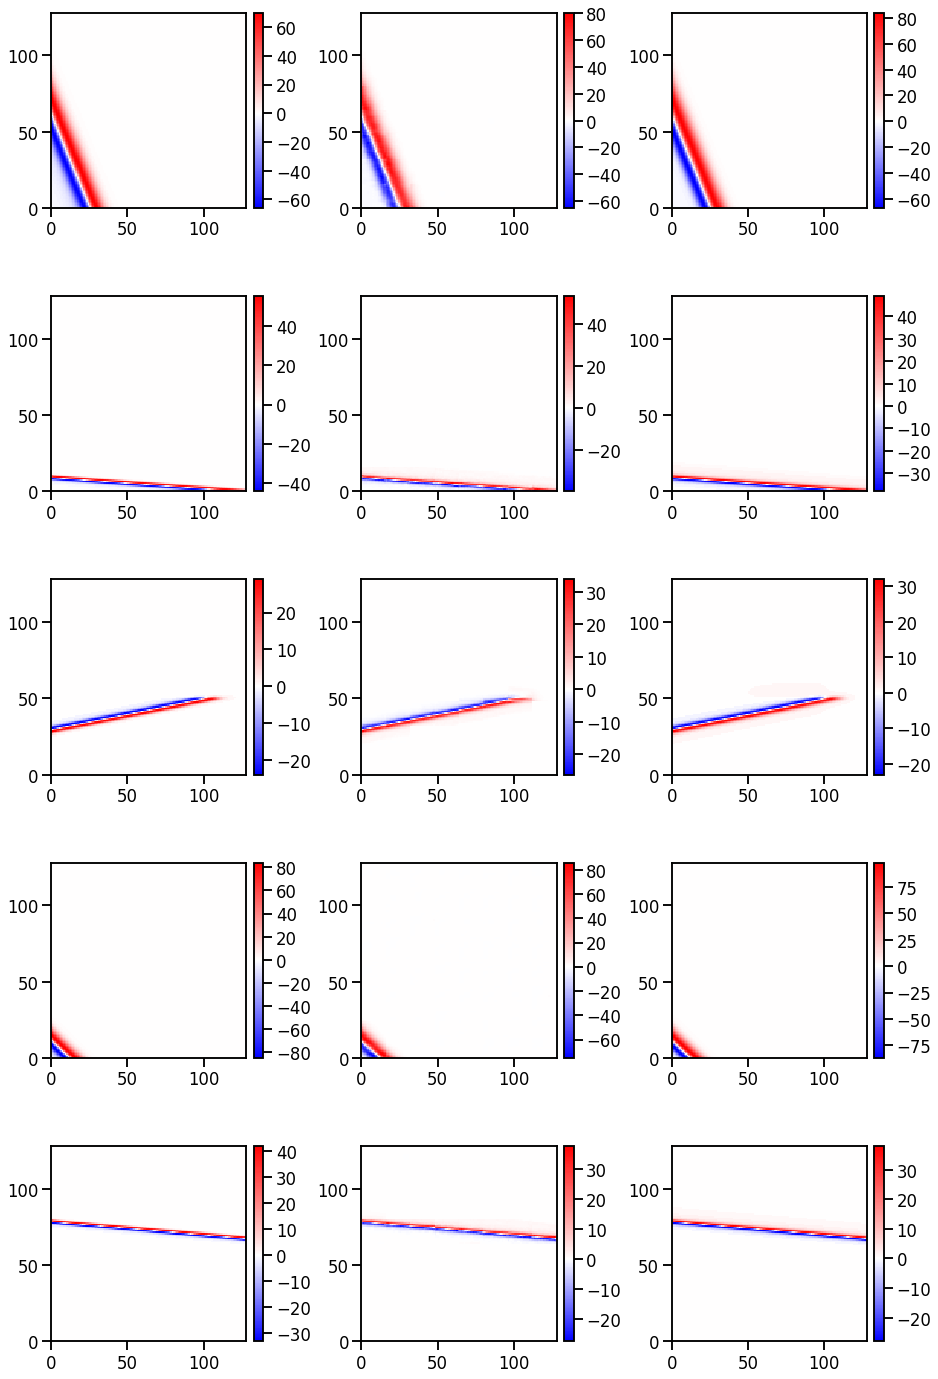

	valid loss:	0.282044
	Saving checkpoint
	peak memory use:	26.902G
Epoch 121 / 200
	lr:		0.000713 -> 0.000710
	time per epoch:	8.018295 seconds
	train loss:	0.229622
	valid loss:	0.242837
	peak memory use:	26.902G
Epoch 122 / 200
	lr:		0.000710 -> 0.000707
	time per epoch:	7.905763 seconds
	train loss:	0.226381
	valid loss:	0.251579
	peak memory use:	26.902G
Epoch 123 / 200
	lr:		0.000707 -> 0.000704
	time per epoch:	7.904940 seconds
	train loss:	0.236147
	valid loss:	0.256317
	peak memory use:	26.902G
Epoch 124 / 200
	lr:		0.000704 -> 0.000702
	time per epoch:	8.002913 seconds
	train loss:	0.226643
	valid loss:	0.245269
	peak memory use:	26.902G
Epoch 125 / 200
	lr:		0.000702 -> 0.000699
	time per epoch:	7.924395 seconds
	train loss:	0.222912
	valid loss:	0.268286
	peak memory use:	26.902G
Epoch 126 / 200
	lr:		0.000699 -> 0.000696
	time per epoch:	7.925433 seconds
	train loss:	0.235279
	valid loss:	0.240661
	peak memory use:	26.902G
Epoch 127 / 200
	lr:		0.000696 -> 0.000693
	time pe

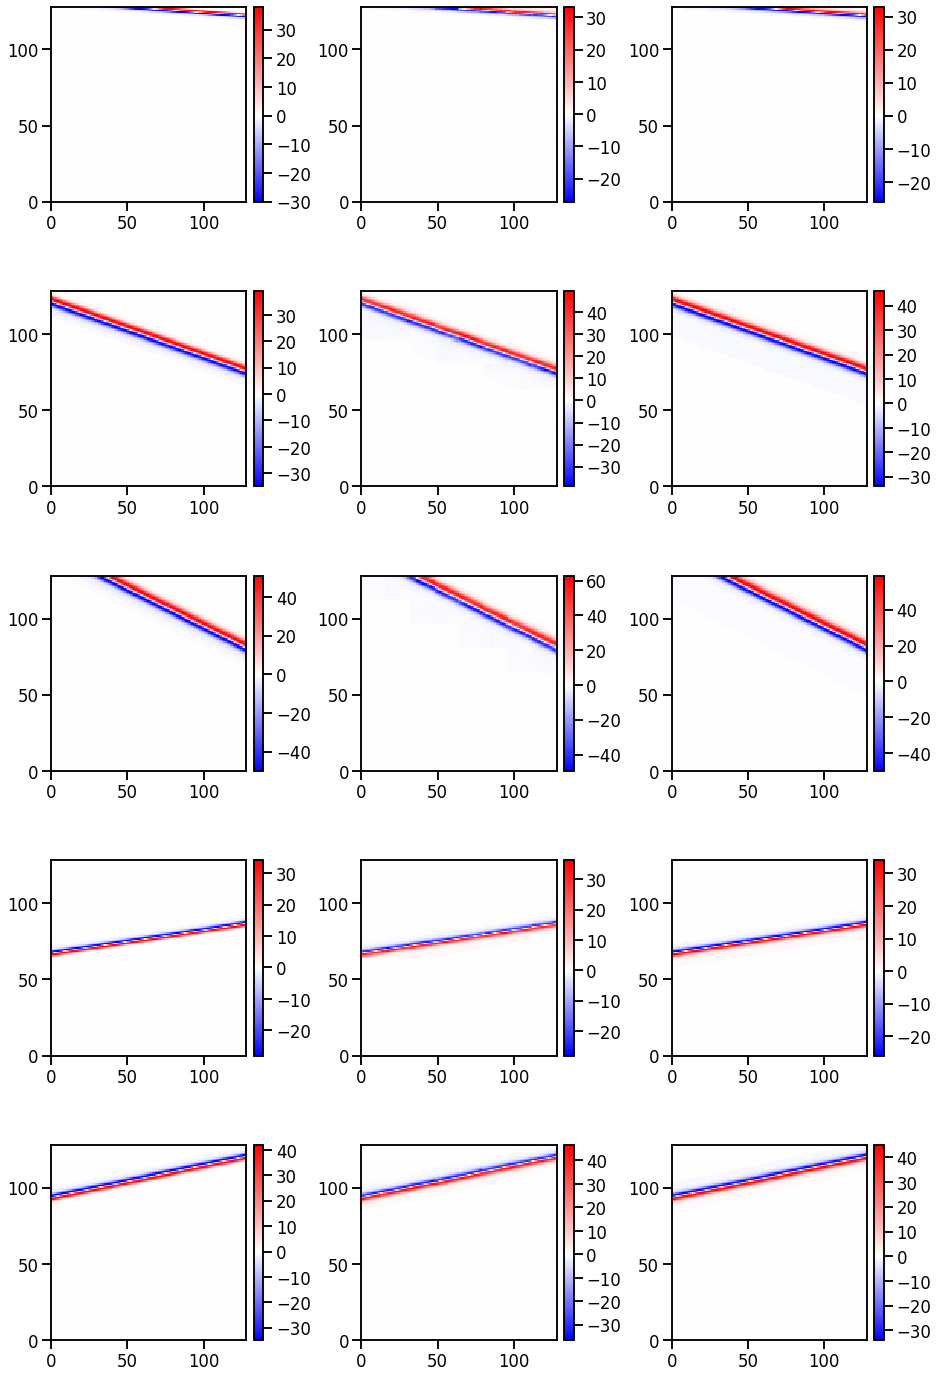

	valid loss:	0.254116
	Saving checkpoint
	peak memory use:	26.902G
Epoch 141 / 200
	lr:		0.000660 -> 0.000658
	time per epoch:	7.974666 seconds
	train loss:	0.220862
	valid loss:	0.240332
	peak memory use:	26.902G
Epoch 142 / 200
	lr:		0.000658 -> 0.000656
	time per epoch:	7.934692 seconds
	train loss:	0.212291
	valid loss:	0.241768
	peak memory use:	26.902G
Epoch 143 / 200
	lr:		0.000656 -> 0.000653
	time per epoch:	7.905495 seconds
	train loss:	0.219969
	valid loss:	0.251895
	peak memory use:	26.902G
Epoch 144 / 200
	lr:		0.000653 -> 0.000651
	time per epoch:	7.994879 seconds
	train loss:	0.212601
	valid loss:	0.252202
	peak memory use:	26.902G
Epoch 145 / 200
	lr:		0.000651 -> 0.000649
	time per epoch:	7.939376 seconds
	train loss:	0.222457
	valid loss:	0.253277
	peak memory use:	26.902G
Epoch 146 / 200
	lr:		0.000649 -> 0.000647
	time per epoch:	7.973905 seconds
	train loss:	0.224329
	valid loss:	0.267073
	peak memory use:	26.902G
Epoch 147 / 200
	lr:		0.000647 -> 0.000644
	time pe

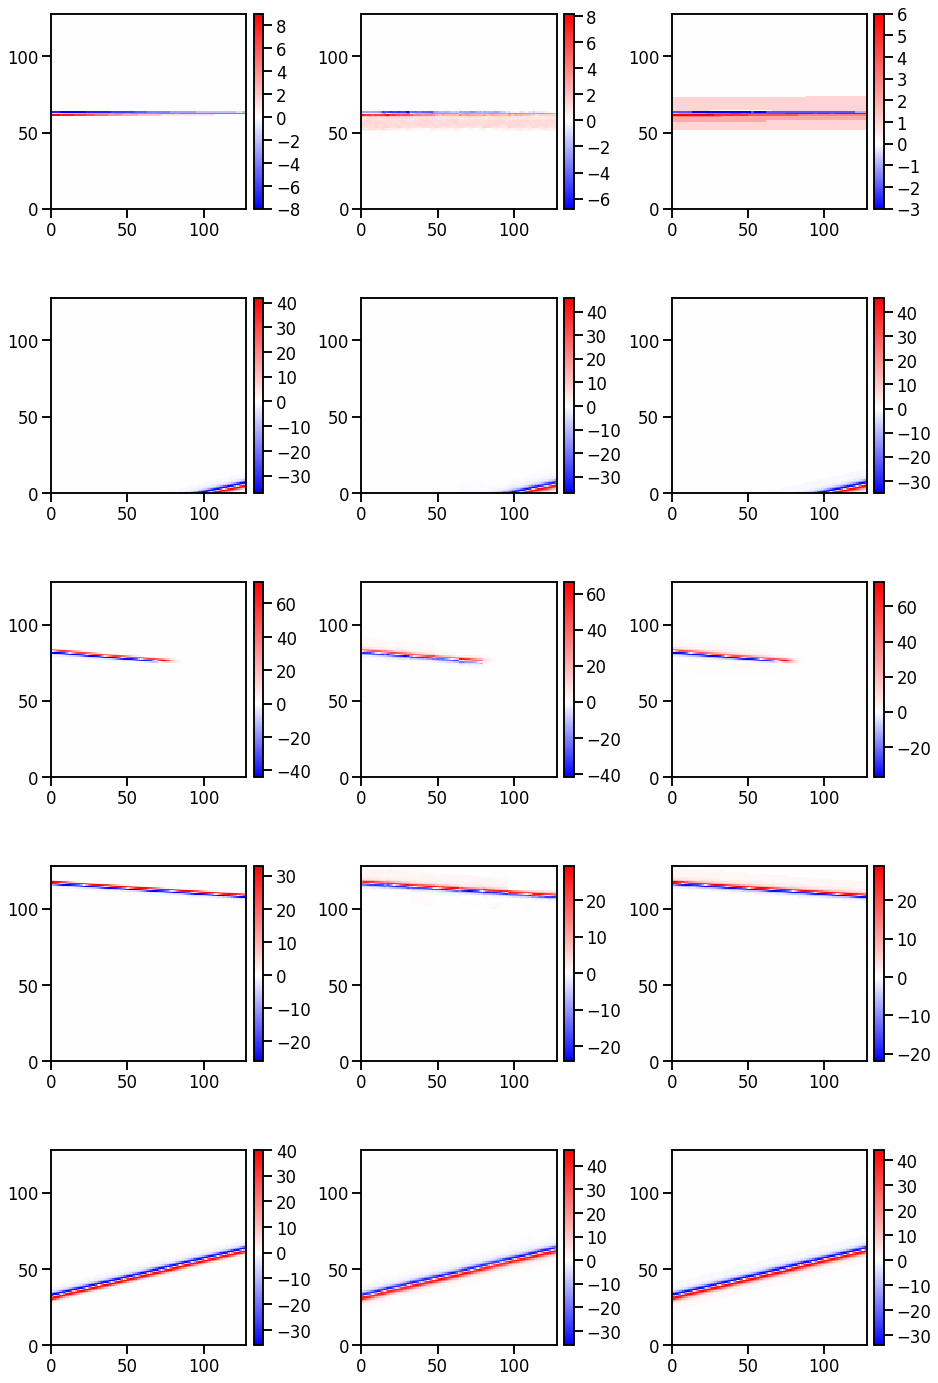

	valid loss:	0.226843
	Saving checkpoint
	peak memory use:	26.902G
Epoch 161 / 200
	lr:		0.000618 -> 0.000616
	time per epoch:	7.974292 seconds
	train loss:	0.205715
	valid loss:	0.255888
	peak memory use:	26.902G
Epoch 162 / 200
	lr:		0.000616 -> 0.000614
	time per epoch:	7.942461 seconds
	train loss:	0.212580
	valid loss:	0.268171
	peak memory use:	26.902G
Epoch 163 / 200
	lr:		0.000614 -> 0.000612
	time per epoch:	7.934278 seconds
	train loss:	0.214919
	valid loss:	0.225991
	peak memory use:	26.902G
Epoch 164 / 200
	lr:		0.000612 -> 0.000610
	time per epoch:	7.977838 seconds
	train loss:	0.214607
	valid loss:	0.231622
	peak memory use:	26.902G
Epoch 165 / 200
	lr:		0.000610 -> 0.000608
	time per epoch:	7.929191 seconds
	train loss:	0.203168
	valid loss:	0.240302
	peak memory use:	26.902G
Epoch 166 / 200
	lr:		0.000608 -> 0.000606
	time per epoch:	7.911360 seconds
	train loss:	0.206025
	valid loss:	0.235728
	peak memory use:	26.902G
Epoch 167 / 200
	lr:		0.000606 -> 0.000605
	time pe

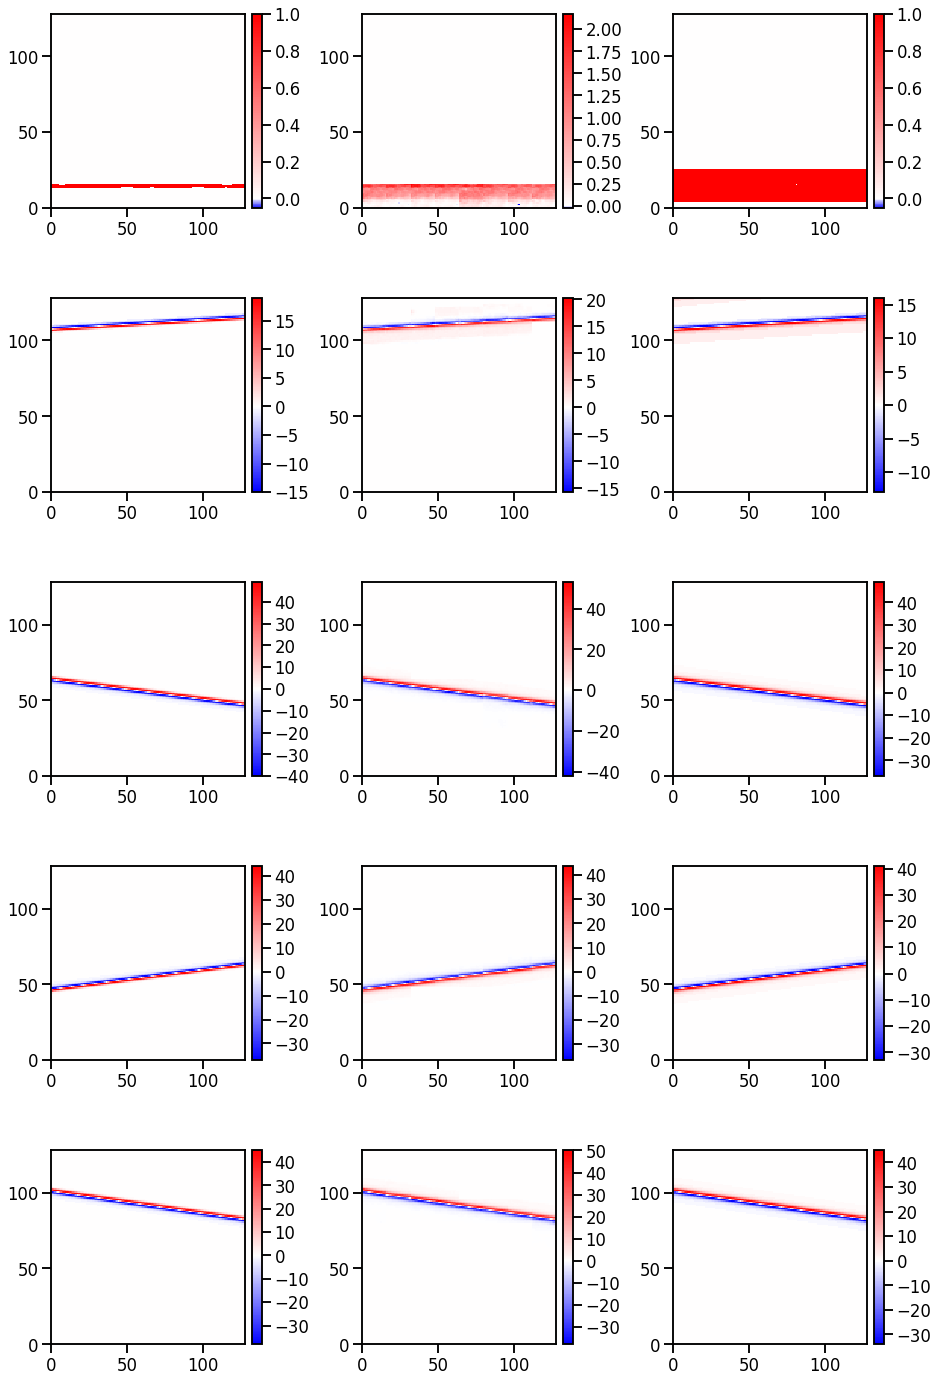

	valid loss:	0.227250
	Saving checkpoint
	peak memory use:	26.902G
Epoch 181 / 200
	lr:		0.000582 -> 0.000581
	time per epoch:	7.980538 seconds
	train loss:	0.209011
	valid loss:	0.273817
	peak memory use:	26.902G
Epoch 182 / 200
	lr:		0.000581 -> 0.000579
	time per epoch:	7.951632 seconds
	train loss:	0.211426
	valid loss:	0.272889
	peak memory use:	26.902G
Epoch 183 / 200
	lr:		0.000579 -> 0.000578
	time per epoch:	7.932305 seconds
	train loss:	0.200419
	valid loss:	0.272723
	peak memory use:	26.902G
Epoch 184 / 200
	lr:		0.000578 -> 0.000576
	time per epoch:	7.982423 seconds
	train loss:	0.200698
	valid loss:	0.231677
	peak memory use:	26.902G
Epoch 185 / 200
	lr:		0.000576 -> 0.000574
	time per epoch:	7.906250 seconds
	train loss:	0.197849
	valid loss:	0.241546
	peak memory use:	26.902G
Epoch 186 / 200
	lr:		0.000574 -> 0.000573
	time per epoch:	7.934901 seconds
	train loss:	0.202526
	valid loss:	0.227227
	peak memory use:	26.902G
Epoch 187 / 200
	lr:		0.000573 -> 0.000571
	time pe

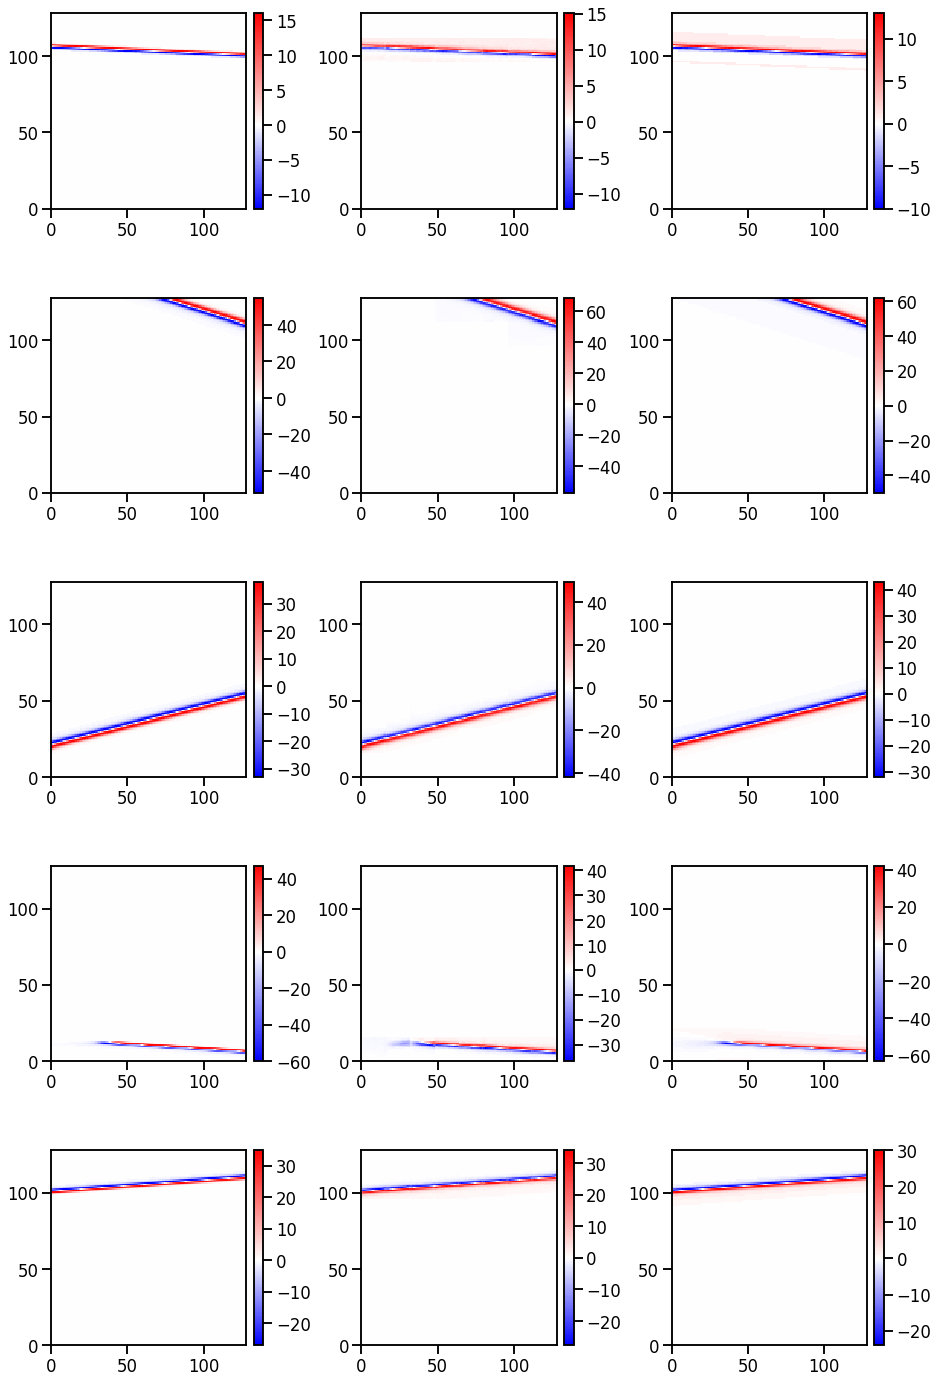

	valid loss:	0.241638
	Saving checkpoint
	peak memory use:	26.902G


In [20]:
model = make_model(image_size, image_size, patch_size, N=3, d_model=256).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'number of parameters = {num_params/1024**2:.2f}M')

model_opt = NoamOpt(
    d_model,
    1, # factor
    20, # warmup
    torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
)

epochs = 200
for epoch in range(epochs):
    print(f'Epoch {epoch + 1} / {epochs}')
    # tells your model that you are training the model. 
    # So effectively layers like dropout, batchnorm etc. 
    # which behave different on the train and test procedures 
    # know what is going on and hence can behave accordingly.
    model.train()
    start = time.time()
    old_lr = get_lr(model_opt.optimizer)
    loss_train = run_epoch(
        loader_train,
        model,
        LossCompute(nn.L1Loss(), model_opt),
        logging_freq=-1
    )
    new_lr = get_lr(model_opt.optimizer)
    print(f'\tlr:\t\t{old_lr:.6f} -> {new_lr:.6f}')
    print(f'\ttime per epoch:\t{time.time() - start:.6f} seconds')
    print(f'\ttrain loss:\t{loss_train:.6f}')
    
    # Validation:
    if epoch % plot_freq == plot_freq - 1:
        plot_func = SimplePlot
    else:
        plot_func = None
    
    loss_valid = run_epoch(
        loader_valid,
        model,
        LossCompute(nn.L1Loss()), # don't use an optimizer and the loss won't be back propagated
        logging_freq=-1, 
        plot_func=plot_func,
        plot_kwargs={'num_samples': 3}
    )
    print(f'\tvalid loss:\t{loss_valid:.6f}')
    
    if epoch % checkpoint_freq == checkpoint_freq - 1:
        print('\tSaving checkpoint')
        fname = f'model_dict_{epoch + 1}'
        torch.save(model.state_dict(), f'{checkpoint_folder}/{fname}.pt')
        torch.save(model.state_dict(), f'{checkpoint_folder}/model_dict_last.pt')
        
    memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
    print(f'\tpeak memory use:\t{memory_cuda/1024 ** 3:.3f}G')